In [4]:
# Import packages that are useful
import hopsworks
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

c:\Users\Merli\anaconda3\envs\id2223\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Log in to Hopsworks
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/194708
Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Get the feature group of wine and create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine dataset, along daily added samples",
                                  labels=["quality"],
                                  query=query)

In [7]:
# Create a train and test split, based on 20% training data 20% validation data and 20% test data. Randomly split
X_train, X_val, X_test, y_train, y_val, y_test = feature_view.train_validation_test_split(validation_size=0.2, test_size=0.2)

# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (1.48s) 


LinearRegression()

In [8]:
# See how the model performs
y_pred = model.predict(X_val)

# Round the predictions to the nearest integer
y_pred = y_pred.round()
metrics = classification_report(y_val, y_pred, output_dict=True)
results = confusion_matrix(y_val, y_pred)

# Get the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

0.5422932330827067


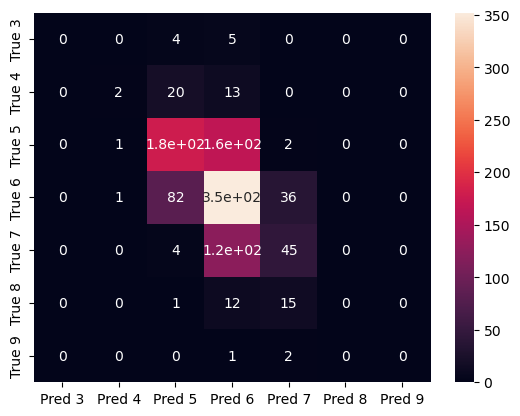

In [9]:
# Create a confusion matrix
df_cm = pd.DataFrame(results, ["True 3", "True 4", "True 5", "True 6", "True 7", "True 8", "True 9"], ["Pred 3", "Pred 4", "Pred 5", "Pred 6", "Pred 7", "Pred 8", "Pred 9"])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()


In [10]:
# Try out a random forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train.values.ravel())

# See how the random forest model performs
y_pred = rf.predict(X_val)
metrics = classification_report(y_val, y_pred, output_dict=True)
results = confusion_matrix(y_val, y_pred)

# Get the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)


0.5526315789473685


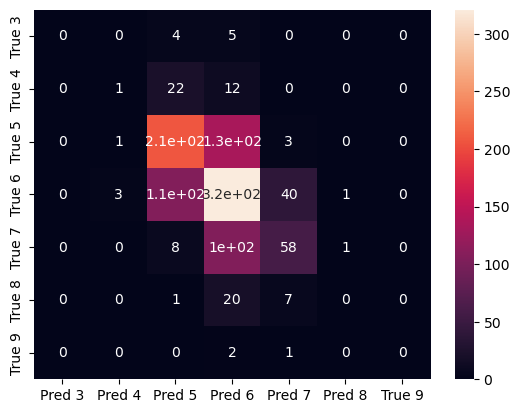

In [11]:
# Create a confusion matrix
df_cm = pd.DataFrame(results, ["True 3", "True 4", "True 5", "True 6", "True 7", "True 8", "True 9"], ["Pred 3", "Pred 4", "Pred 5", "Pred 6", "Pred 7", "Pred 8", "True 9"])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()


In [12]:
# Try out a random forest regressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train.values.ravel())

# See how the random forest model performs
y_pred = rf.predict(X_val)
y_pred = y_pred.round()
metrics = classification_report(y_val, y_pred, output_dict=True)
results = confusion_matrix(y_val, y_pred)

# Get the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

0.5535714285714286


In [13]:
# Create a confusion matrix
df_cm = pd.DataFrame(results, ["True 3", "True 4", "True 5", "True 6", "True 7", "True 8", "True 9"], ["Pred 3", "Pred 4", "Pred 5", "Pred 6", "Pred 7", "Pred 8", "Pred 9"])

In [14]:
# Create a simple naive bayes classifier
nb = GaussianNB()
nb.fit(X_train, y_train.values.ravel())

# See how the naive bayes model performs
y_pred = nb.predict(X_val)
metrics = classification_report(y_val, y_pred, output_dict=True)
results = confusion_matrix(y_val, y_pred)

# Get the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

0.4558270676691729


In [15]:
# Train a KNN 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train.values.ravel())

# See how the KNN model performs
y_pred = knn.predict(X_val)
metrics = classification_report(y_val, y_pred, output_dict=True)
results = confusion_matrix(y_val, y_pred)

# Get the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
0,7.2,0.62,0.06,2.70,0.077,15.0,85.0,0.99746,3.51,0.54,9.5
6,6.7,0.31,0.33,2.00,0.033,12.0,74.0,0.99064,3.29,0.65,12.5
7,6.1,0.32,0.25,1.70,0.034,37.0,136.0,0.99200,3.47,0.50,10.8
8,8.0,0.34,0.25,6.40,0.035,38.0,103.0,0.99148,2.91,0.23,12.2
9,7.2,0.53,0.14,2.10,0.064,15.0,29.0,0.99323,3.35,0.61,12.1
...,...,...,...,...,...,...,...,...,...,...,...
5314,5.8,0.29,0.33,3.70,0.029,30.0,88.0,0.98994,3.25,0.42,12.3
5315,6.5,0.30,0.28,11.45,0.041,29.0,109.0,0.99418,2.98,0.30,10.9
5316,8.9,0.33,0.32,1.50,0.047,11.0,200.0,0.99540,3.19,0.46,9.4
5317,7.2,0.18,0.31,1.10,0.045,20.0,73.0,0.99250,3.32,0.40,10.8
